In [52]:
from __future__ import print_function
import argparse
import geopandas as gpd
import json
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pandas as pd
import pprint
import pylab as pl
import requests
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
import seaborn as sns
from sklearn import preprocessing
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import shutil 
import sys
import urllib
import urllib.request 
import zipfile
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode
    
from pandas.io.json import json_normalize
from shapely.geometry import Point
from ast import literal_eval

In [53]:
def read_in_data(city):
    '''
    reads in files
    '''
    path             = 'coffee_data/'
    crs              = {'init': 'epsg:4326'}
    '''
    WGS84 (EPSG: 4326) +init=epsg:4326 
    +proj=longlat+ellps=WGS84 +
    datum=WGS84 +no_defs+towgs84=0,0,0
    ## CRS used by Google Earth and the U.S. Department of Defense for all their mapping.  
    Tends to be used for global reference systems. GPS satellites broadcast the predicted WGS84 orbits
    '''
    
    def lon_lat_str_to_tuple(string):
        '''
        because coords are converted from tuple to string when 
        '''
        string = string.split(', ')
        lon = float(string[0].split('(')[1])
        lat = float(string[1].split(')')[0])
        return (lon, lat)
    
    # read in map
    map_df           = pd.read_csv(path + str(city) + '/{}_map.csv'.format(city))
    map_df_geo       = gpd.read_file(path + str(city) + '/map_geo_{}.shp'.format(city))
    map_df.geometry  = map_df_geo.geometry
    map_gdf          = gpd.GeoDataFrame(map_df, crs=crs, geometry=map_df.geometry)
    map_gdf.coords   = map_gdf.coords.apply(lambda x: lon_lat_str_to_tuple(x))
    
    # read in data
    data_df          = pd.read_csv(path + str(city) + '/{}_data.csv'.format(city))
    data_df_geo      = gpd.read_file(path + str(city) + '/data_geo_{}.shp'.format(city))
    data_df.geometry = data_df_geo.geometry
    data_gdf         = gpd.GeoDataFrame(data_df, crs=crs, geometry=data_df.geometry)

    return map_gdf, data_gdf

In [54]:
def megalist(list_of_cities,path):
    
    if len(list_of_cities) == 0:
        print('no cities provided')
        return
    
    # make base dfs
    if not os.path.isfile(path + str(list_of_cities[0]) + '/{}_map.csv'.format(list_of_cities[0])):
        save_files([list_of_cities[0]])
    mega_map, mega_data = read_in_data(list_of_cities[0])
#     print(mega_map)
    
    if len(list_of_cities) == 1:
        return mega_map, mega_data
    
    for city in list_of_cities[1:]:
        if not os.path.isfile(path + str(city) + '/{}_map.csv'.format(city)):
            save_files([city])
        temp_map, temp_data = read_in_data(city)
        mega_map  = gpd.GeoDataFrame(pd.concat([mega_map, temp_map], ignore_index=True))
        mega_data = gpd.GeoDataFrame(pd.concat([mega_data, temp_data], ignore_index=True))
#     print(mega_data.head())
    
    
    # If these already exist they should be dropped as they will be added
    if any('geom_mean_tt_shop_x' in s for s in mega_data.columns):
        mega_data.drop(columns=['geom_mean_tt_shop_x'],inplace=True)
    if any('geom_mean_tt_shop_y' in s for s in mega_data.columns):
        mega_data.drop(columns=['geom_mean_tt_shop_y'],inplace=True)
    
    if not os.path.isdir(path + 'COFFEE'):
        os.mkdir(path + 'COFFEE')
    # save map data
    mega_map.geometry.to_file(path + 'COFFEE' + '/map_geo_{}.shp'.format(city))
    map_df = pd.DataFrame(mega_map.values, columns=mega_map.columns)
    map_df.to_csv(path + 'COFFEE' + '/{}_map.csv'.format('COFFEE'), encoding='utf-8', index=False)
    # save store data
    mega_data.geometry.to_file(path + 'COFFEE' + '/data_geo_{}.shp'.format(city))
    data_df = pd.DataFrame(mega_data.values, columns=mega_data.columns)
    data_df.to_csv(path + 'COFFEE' + '/{}_data.csv'.format('COFFEE'), encoding='utf-8', index=False)
    
    return mega_map, mega_data

In [55]:
have_uber_info=['Pittsburgh','Boston','San Francisco','Washington']
#Los Angeles did not record poly coords correctly

list_of_cities=['Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlottesville', 'Columbus', 'Denver',
        'New York', 'Seattle', 'Dallas', 'San Francisco', 'Portland', 'Pittsburgh', 'Miami',
        'Chicago', 'Cleveland', 'Los Angeles', 'New Orleans', 'Detroit', 'Salt Lake City',
        'Philadelphia', 'Boulder', 'Santa Fe', 'Washington', 'Honolulu', 'Las Vegas', 'Minneapolis',
        'Oakland', 'San Diego', 'Charlotte', 'Houston']

cols_to_drop_from_uber=['geometry']
path=os.getcwd()+'/'+'coffee_data/'

for city in have_uber_info:
    print(city)
    df_city=pd.read_csv(path+str(city)+'/{}_data.csv'.format(city))
#     print(df_city.shape)
    df_city_uber=pd.read_csv(path+str(city)+'/{}_uber_data.csv'.format(city))
    
    print(df_city.columns)
#     df_city_uber.drop(columns='geometry',inplace=True)
#     temp1 = [list(df_city_uber.columns)[-1]]
    if any('geom_mean_tt_shop' in s for s in df_city.columns):
        df_city.drop(columns=['geom_mean_tt_shop'],inplace=True)
#     print(df_city_uber.head())
    df_city = pd.merge(df_city, pd.DataFrame(df_city_uber['geom_mean_tt_shop']), left_index=True, right_index=True, how='outer')
#     print(df_city.shape)
#     df_city=df_New.copy(deep=True)
    if os.path.isfile(path + str(city) + '/{}_data.csv'.format(city)):
        os.remove(path + str(city) + '/{}_data.csv'.format(city))
        df_city.to_csv(path + str(city) + '/{}_data.csv'.format(city), encoding='utf-8', index=False)
        print('saved for city {}'.format(city))


Pittsburgh
Index(['Store_Name', 'Categories', 'B_Id', 'Location', 'Zip_Code', 'Price',
       'Rating', 'Review_Count', 'geometry', 'State', 'County', 'City', 'Name',
       'RegionID', 'chain', 'price_int', 'strictly_coffee', 'coffee_is_cat',
       'breakfast_and_brunch', 'bakeries', 'diner', 'deli',
       'ice_cream_and_froyo', 'juice_and_smoothie', 'primary_category',
       'geom_mean_tt_shop'],
      dtype='object')
saved for city Pittsburgh
Boston
Index(['Store_Name', 'Categories', 'B_Id', 'Location', 'Zip_Code', 'Price',
       'Rating', 'Review_Count', 'geometry', 'State', 'County', 'City', 'Name',
       'RegionID', 'chain', 'price_int', 'strictly_coffee', 'coffee_is_cat',
       'breakfast_and_brunch', 'bakeries', 'diner', 'deli',
       'ice_cream_and_froyo', 'juice_and_smoothie', 'primary_category',
       'geom_mean_tt_shop'],
      dtype='object')
saved for city Boston
San Francisco
Index(['Store_Name', 'Categories', 'B_Id', 'Location', 'Zip_Code', 'Price',
       'Rati

In [56]:
list_no_uber=[item for item in list_of_cities if item not in have_uber_info]
#list_no_uber=['Atlanta']
print(list_no_uber)
for city in list_no_uber:
    df_city=pd.read_csv(path+str(city)+'/{}_data.csv'.format(city))
    df_city['geom_mean_tt_shop']=np.nan
    if os.path.isfile(path + str(city) + '/{}_data.csv'.format(city)):
        os.remove(path + str(city) + '/{}_data.csv'.format(city))
        df_city.to_csv(path + str(city) + '/{}_data.csv'.format(city), encoding='utf-8', index=False)
        print('saved for city {}'.format(city))

['Atlanta', 'Austin', 'Baltimore', 'Charlottesville', 'Columbus', 'Denver', 'New York', 'Seattle', 'Dallas', 'Portland', 'Miami', 'Chicago', 'Cleveland', 'Los Angeles', 'New Orleans', 'Detroit', 'Salt Lake City', 'Philadelphia', 'Boulder', 'Santa Fe', 'Honolulu', 'Las Vegas', 'Minneapolis', 'Oakland', 'San Diego', 'Charlotte', 'Houston']
saved for city Atlanta
saved for city Austin
saved for city Baltimore
saved for city Charlottesville
saved for city Columbus
saved for city Denver
saved for city New York
saved for city Seattle
saved for city Dallas
saved for city Portland
saved for city Miami
saved for city Chicago
saved for city Cleveland
saved for city Los Angeles
saved for city New Orleans
saved for city Detroit
saved for city Salt Lake City
saved for city Philadelphia
saved for city Boulder
saved for city Santa Fe
saved for city Honolulu
saved for city Las Vegas
saved for city Minneapolis
saved for city Oakland
saved for city San Diego
saved for city Charlotte
saved for city Houst

In [57]:
list_of_cities=['Atlanta', 'Austin', 'Baltimore', 'Boston', 'Charlottesville', 'Columbus', 'Denver',
        'New York', 'Seattle', 'Dallas', 'San Francisco', 'Portland', 'Pittsburgh', 'Miami',
        'Chicago', 'Cleveland', 'Los Angeles', 'New Orleans', 'Detroit', 'Salt Lake City',
        'Philadelphia', 'Boulder', 'Santa Fe', 'Washington', 'Honolulu', 'Las Vegas', 'Minneapolis',
        'Oakland', 'San Diego', 'Charlotte', 'Houston']
path = 'coffee_data/'
mega_map, mega_data = megalist(list_of_cities,path)

In [58]:
#mega_data.drop(columns=['geom_mean_tt_shop_x','geom_mean_tt_shop_y'],inplace=True)
mega_data.head()

,Store_Name,Categories,B_Id,Location,Zip_Code,Price,Rating,Review_Count,geometry,State,...,strictly_coffee,coffee_is_cat,breakfast_and_brunch,bakeries,diner,deli,ice_cream_and_froyo,juice_and_smoothie,primary_category,geom_mean_tt_shop
0,Brash Coffee,['Coffee & Tea'],_0jwczJo5LaSo8e6liyS4Q,"(33.842003, -84.386072)",30305.0,$$,4.5,25,POINT (-84.386072 33.842003),GA,...,True,True,False,False,False,False,False,False,strictly_coffee,NaN
1,Astor Court,"['Breakfast & Brunch', 'Tea Rooms']",e9RQz4EG1ThimFpZpGaGiA,"(33.839928, -84.3825594)",30305.0,$$$,3.5,38,POINT (-84.38255940000001 33.839928),GA,...,False,False,True,False,False,False,False,False,breakfast_and_brunch,NaN
2,Souper Jenny,"['Sandwiches', 'Soup', 'Breakfast & Brunch']",mAW0poOKFdoaBFXAE-xjJA,"(33.8428047, -84.3864743)",30305.0,$$,4.0,240,POINT (-84.3864743 33.8428047),GA,...,False,False,True,False,False,False,False,False,breakfast_and_brunch,NaN
3,Peachtree Road Farmers Market,['Farmers Market'],CCCFdTbkRWh8WAQK_x1T-A,"(33.831499, -84.38565)",30305.0,$$,4.0,52,POINT (-84.38565 33.831499),GA,...,False,False,False,False,False,False,False,False,other,NaN
4,Starbucks,['Coffee & Tea'],Ma_eP7RX1vWAhmjZTY7zyw,"(33.835393, -84.382662088102)",30305.0,$,3.0,33,POINT (-84.38266208810199 33.835393),GA,...,True,True,False,False,False,False,False,False,chain,NaN


(-0.5, 1199.5, 599.5, -0.5)

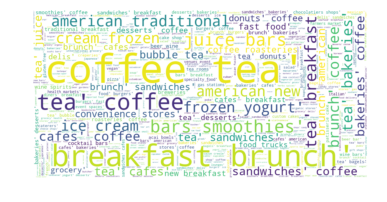

In [59]:
#key words in all categories
from wordcloud import WordCloud, STOPWORDS
all_coffee_words = ' '.join(mega_data['Categories'].values.astype(str)).lower()
wc = WordCloud(background_color="white", max_words=2000, stopwords=set(STOPWORDS),
               width=1200, height=600, random_state=0)
wc.generate(all_coffee_words)
#wc.to_file('/gh/srcole.github.io/assets/insightfellows/wordcloud.png')

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

In [60]:


chains =list(pd.DataFrame(mega_data.Store_Name.value_counts()[mega_data.Store_Name.value_counts()>=5]).index)
# bagels and donuts together??
# find donut stores (very important - life without donuts is sad and meaningless)
donut_spellings = ['donut', 'Donut', 'Doughnut', 'doughnut', 'dough', 'Dough'] 
donut_stores = []
for donut in donut_spellings:
    donut_stores.append(mega_data[mega_data['Store_Name'].str.contains('spelling')]['Store_Name'].unique())